In [4]:
import contractions
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from functions import preprocess
import re

def test_classifier(classifier, pattern, text_train, labels_train, text_val, labels_val):
    clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                        TfidfTransformer(), classifier)
    clf.fit(preprocess(text_train), labels_train)
    pred = clf.predict(preprocess(text_val))
    print(metrics.classification_report(labels_val, pred, digits=3))

In [ ]:
from nltk.tokenize import TweetTokenizer
nltk_pat = re.compile(TweetTokenizer().WORD_RE.pattern, flags=re.I|re.VERBOSE|re.UNICODE)

In [ ]:
with open("tweeteval/datasets/irony/train_text.txt", "r") as f:
    irony_train_text = f.read().rstrip()
irony_train_labels = np.loadtxt("tweeteval/datasets/irony/train_labels.txt")
with open("tweeteval/datasets/irony/val_text.txt", "r") as f:
    irony_val_text = f.read().rstrip()
irony_val_labels = np.loadtxt("tweeteval/datasets/irony/val_labels.txt")
with open("pattern.txt", "r") as f:
    pattern = re.compile(f.read().rstrip(), flags=re.UNICODE)
    
classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
test_classifier(classifier, pattern, irony_train_text, irony_train_labels, irony_val_text, irony_val_labels)

              precision    recall  f1-score   support

         0.0      0.675     0.685     0.680       499
         1.0      0.650     0.638     0.644       456

    accuracy                          0.663       955
   macro avg      0.662     0.662     0.662       955
weighted avg      0.663     0.663     0.663       955



Own tokenizer:
__________________________________
acc_score: 0.635 ±0.01
      precision    recall    f1-score    support
--  -----------  --------  ----------  ---------
 0        0.607     0.612       0.609    567.000
 1        0.623     0.617       0.620    578.000

NLTK tokenizer:
__________________________________
acc_score: 0.639 ±0.02
      precision    recall    f1-score    support
--  -----------  --------  ----------  ---------
 0        0.610     0.604       0.607    567.000
 1        0.607     0.614       0.610    578.000


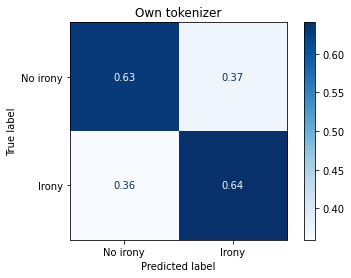

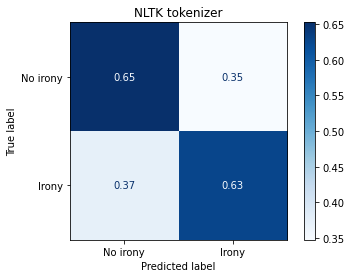

In [22]:
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from nltk.tokenize import TweetTokenizer
from pprint import pprint
from tabulate import tabulate

dataset = "irony"
if "/" in dataset:
    conf_mat_labels = ["Neutral", "Against", "In Favor"]
    labels = [0, 1, 2]
else:
    conf_mat_labels = ["No irony", "Irony"]
    labels = [0, 1]

with open(f"tweeteval/datasets/{dataset}/train_text.txt", "r") as f:
    x = f.read().rstrip()
y = np.loadtxt(f"tweeteval/datasets/{dataset}/train_labels.txt", dtype=int)
with open("pattern.txt", "r") as f:
    pattern = re.compile(f.read().rstrip(), flags=re.UNICODE)
nltk_pat = re.compile(TweetTokenizer().WORD_RE.pattern, flags=re.I|re.VERBOSE|re.UNICODE)
x = preprocess(x)

n_splits = 5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

acc_scores_own = np.empty((n_splits))
acc_scores_nltk = np.empty((n_splits))
conf_mats_own = []
conf_mats_nltk = []
score_dict_own = {0: {"recall": [], "precision": [], "f1-score": [], "support": []},
                  1: {"recall": [], "precision": [], "f1-score": [], "support": []}}
score_dict_nltk = {0: {"recall": [], "precision": [], "f1-score": [], "support": []},
                   1: {"recall": [], "precision": [], "f1-score": [], "support": []}}
if 2 in labels:
    score_dict_own[2] = {"recall": [], "precision": [], "f1-score": [], "support": []}
    score_dict_nltk[2] = {"recall": [], "precision": [], "f1-score": [], "support": []}


for j, (train_index, val_index) in enumerate(kf.split(x, y)):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    if 2 in labels:
        classifier = MLPClassifier(solver='adam', learning_rate='adaptive', activation='tanh', max_iter=500)
    else:
        classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
    clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                        TfidfTransformer(), classifier)
    clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    conf_mats_own.append(confusion_matrix(y_val, y_pred_val))

    for i in labels:
        scores = metrics.precision_recall_fscore_support(y_val, y_pred_val)
        score_dict_own[i]["recall"] = scores[0][i]
        score_dict_own[i]["precision"] = scores[1][i]
        score_dict_own[i]["f1-score"] = scores[2][i]
        score_dict_own[i]["support"] = scores[3][i]

    acc_scores_own[j] = accuracy_score(y_val, y_pred_val)

    if 2 in labels:
        classifier = MLPClassifier(solver='adam', learning_rate='adaptive', activation='tanh', max_iter=500)
    else:
        classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
    clf = make_pipeline(CountVectorizer(token_pattern=nltk_pat, strip_accents="unicode"),
                        TfidfTransformer(), classifier)
    clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    conf_mats_nltk.append(confusion_matrix(y_val, y_pred_val))

    for i in labels:
        scores = metrics.precision_recall_fscore_support(y_val, y_pred_val)
        score_dict_nltk[i]["recall"] = scores[0][i]
        score_dict_nltk[i]["precision"] = scores[1][i]
        score_dict_nltk[i]["f1-score"] = scores[2][i]
        score_dict_nltk[i]["support"] = scores[3][i]

    acc_scores_nltk[j] = accuracy_score(y_val, y_pred_val)


print("Own tokenizer:\n__________________________________")
print(f"acc_score: {np.mean(acc_scores_own):.3f} ±{np.std(acc_scores_own):.2f}")
for i in labels:
    for key in score_dict_own[i].keys():
        score_dict_own[i][key] = np.mean(score_dict_own[i][key])
header = ["precision", "recall", "f1-score", "support"]
table = [[l, *[score_dict_own[l][k] for k in header]] for l in labels]
print(tabulate(table, headers=header, floatfmt=".3f"))
avg_conf_mat = normalize(np.mean(np.stack(conf_mats_own, axis=2), axis=2), norm="l1")
display = ConfusionMatrixDisplay(avg_conf_mat, display_labels=conf_mat_labels)
fig = display.plot(cmap=plt.cm.Blues)
fig.ax_.set_title("Own tokenizer")
print()
print("NLTK tokenizer:\n__________________________________")
print(f"acc_score: {np.mean(acc_scores_nltk):.3f} ±{np.std(acc_scores_nltk):.2f}")
for i in [0, 1]:
    for key in score_dict_nltk[i].keys():
        score_dict_nltk[i][key] = np.mean(score_dict_nltk[i][key])
header = ["precision", "recall", "f1-score", "support"]
table = [[l, *[score_dict_nltk[l][k] for k in header]] for l in labels]
print(tabulate(table, headers=header, floatfmt=".3f"))
avg_conf_mat = normalize(np.mean(np.stack(conf_mats_nltk, axis=2), axis=2), norm="l1")
display = ConfusionMatrixDisplay(avg_conf_mat, display_labels=conf_mat_labels)
fig = display.plot(cmap=plt.cm.Blues)
fig.ax_.set_title("NLTK tokenizer");

In [16]:
metrics.precision_recall_fscore_support(y_val, y_pred_val)

(array([0.61977186, 0.61066236]),
 array([0.57495591, 0.65397924]),
 array([0.59652333, 0.63157895]),
 array([567, 578]))

In [ ]:
table

[[0, 0.6102292768959435, 0.6038394415357766, 0.6070175438596491, 567.0],
 [1, 0.6072664359861591, 0.6136363636363636, 0.6104347826086957, 578.0]]

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
test_classifier(classifier, pattern, irony_train_text, irony_train_labels, irony_val_text, irony_val_labels)

              precision    recall  f1-score   support

         0.0      0.709     0.523     0.602       499
         1.0      0.595     0.765     0.669       456

    accuracy                          0.639       955
   macro avg      0.652     0.644     0.636       955
weighted avg      0.654     0.639     0.634       955



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
text_clf = Pipeline([("vect", CountVectorizer(token_pattern=pattern)),
             ("tfidf", TfidfTransformer()), ("clf", SGDClassifier())])
parameters = {
    "vect__strip_accents": ("unicode", None),
    "vect__ngram_range": [(1,1), (1,2), (2,2)],
    "tfidf__use_idf": (True, False),
    "clf__max_iter": (1000, 5000, 10000),
    "clf__learning_rate": ("optimal", "adaptive", "constant"),
    "clf__eta0": (1, 0.1, 0.01, 0.001, 0.0001),
    "clf__n_iter_no_change": (10, 100, 500, 1000, 5000)
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf.fit(preprocess(irony_train_text), irony_train_labels)
pred = gs_clf.predict(preprocess(text_val))
print(metrics.classification_report(labels_val, pred, digits=3))

KeyboardInterrupt: 

In [ ]:
pred = gs_clf.predict(preprocess(irony_val_text))
print(metrics.classification_report(irony_val_labels, pred, digits=3))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e4cdc3a5-dd4a-4d72-a71a-972cea883107' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>